References:
* https://medium.com/@zhonghong9998/anomaly-detection-in-time-series-data-using-lstm-autoencoders-51fd14946fa3
* https://www.semanticscholar.org/paper/Unsupervised-Anomaly-Detection-in-Time-Series-Using-Provotar-Linder/8b07f61e5807ab23663360735eb6ed4ac0c0d6f2
* https://www.semanticscholar.org/paper/Anomaly-detection-in-rotating-machinery-using-based-Patra-Sethi/71d30898d623e17a1c3dd13ac902e00214093154


# Importing libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
# import helper function script
import script_EDA as scp

# Load Data

In [4]:
df = pd.read_csv('../all_flights_preprocessed_with_and_without_leaks.csv', index_col=0,sep=';')
df.head()

,Flight,ID,VALUE_FOB,VALUE_FOB_EXPECTED,VALUE_FOB_DIFF,FUEL_USED_1,FUEL_USED_2,FUEL_USED_3,FUEL_USED_4,TOTAL_FUEL_USED,FUEL_LOADED_FOB,VALUE_FUEL_QTY_CT,VALUE_FUEL_QTY_FT1,VALUE_FUEL_QTY_FT2,VALUE_FUEL_QTY_FT3,VALUE_FUEL_QTY_FT4,VALUE_FUEL_QTY_LXT,VALUE_FUEL_QTY_RXT,LEAK_FLOW,TARGET
UTC_TIME,,,,,,,,,,,,,,,,,,,,
2016-08-26 06:37:00,37_16.0,16.0_F-RBAJ,37228.333333,36800.890320,-427.443014,623.952576,621.907532,626.026062,618.223511,2490.109680,39291.0,4017.0,1889.0,2656.0,2685.0,1871.0,12225.0,11892.0,0.16,1
2016-08-26 06:37:01,37_16.0,16.0_F-RBAJ,37229.435418,36799.774841,-429.660577,624.230164,622.183716,626.308105,618.503174,2491.225159,39291.0,4013.0,1889.0,2656.0,2684.0,1870.0,12228.0,11895.0,0.16,1
2016-08-26 06:37:02,37_16.0,16.0_F-RBAJ,37230.730430,36798.591370,-432.139060,624.506348,622.460754,626.624023,618.817505,2492.408630,39291.0,4009.0,1889.0,2656.0,2684.0,1870.0,12230.0,11896.0,0.16,1
2016-08-26 06:37:03,37_16.0,16.0_F-RBAJ,37229.565736,36797.446716,-432.119020,624.782471,622.771118,626.904785,619.094910,2493.553284,39291.0,4004.0,1889.0,2656.0,2684.0,1869.0,12232.0,11899.0,0.16,1
2016-08-26 06:37:04,37_16.0,16.0_F-RBAJ,37228.364136,36796.311584,-432.052551,625.091919,623.043701,627.182129,619.370667,2494.688416,39291.0,3999.0,1888.0,2656.0,2684.0,1869.0,12233.0,11903.0,0.16,1


## Preprocess data

Re-ensure that all flights have the same length, this is crucial for LSTM

In [5]:
def create_sequences_by_flight(data, seq_length, flight_id_col):
    sequences = []
    flight_ids = []
    targets = []
    leak_flows = []
    # Group data by flight ID
    grouped = data.groupby(flight_id_col)
    
    for flight_id, group in grouped:
        # Convert group to numpy array
        flight_data = group.drop(columns=[flight_id_col, 'ID', 'LEAK_FLOW', 'TARGET']).values
        target_data = group['TARGET'].values
        leak_flow = group['LEAK_FLOW'].values
        # Extract sequences of the specified length
        for i in range(len(flight_data) - seq_length + 1):
            sequences.append(flight_data[i:i + seq_length])
            flight_ids.append(flight_id)
            targets.append(target_data[i:i + seq_length])
            leak_flows.append(leak_flow[i:i + seq_length])
            
    return np.array(sequences), np.array(flight_ids), np.array(targets), np.array(leak_flows)

In [30]:
# Filter the normal data
normal_data = df[df['TARGET'] == 0]
anomalous_data = df[df['TARGET'] == 1]

# Group the data by Flight
grouped = normal_data.groupby('Flight')

# Extract the flight indices
flight_indices = list(grouped.groups.keys())

# Train-Test Split on flight indices
train_indices, test_indices = train_test_split(flight_indices, test_size=0.2, random_state=42)

# Create train and test datasets based on the split flight indices, 20% of the flight data is used for testing
train_data = normal_data[normal_data['Flight'].isin(train_indices)].drop(['Flight', 'ID', 'LEAK_FLOW', 'TARGET'], axis=1).values
test_data = normal_data[normal_data['Flight'].isin(test_indices)].drop(['Flight', 'ID', 'LEAK_FLOW', 'TARGET'], axis=1).values

# keep this as I will introduce them again after
train_dropped_columns = normal_data[normal_data['Flight'].isin(train_indices)][['Flight', 'ID', 'LEAK_FLOW', 'TARGET']].reset_index()
test_dropped_columns = normal_data[normal_data['Flight'].isin(test_indices)][['Flight', 'ID', 'LEAK_FLOW', 'TARGET']].reset_index()



# Convert to numpy arrays if needed
train_data = np.array(train_data)
test_data = np.array(test_data)

## Standarize

In [31]:
# Normalize the data
scaler = StandardScaler()

normal_data_train_scaled = scaler.fit_transform(train_data)
normal_data_test_scaled = scaler.transform(test_data)

anomalous_data_scaled = scaler.transform(anomalous_data.drop(['Flight', 'ID', 'LEAK_FLOW', 'TARGET'], axis=1).values
                                         )

anomalous_dropped_columns = anomalous_data[['Flight', 'ID', 'LEAK_FLOW', 'TARGET']].reset_index()


In [32]:
remaining_columns = normal_data.drop(['Flight', 'ID', 'LEAK_FLOW', 'TARGET'], axis=1).columns

normal_data_train_scaled_df = pd.DataFrame(normal_data_train_scaled, columns=remaining_columns)
normal_data_test_scaled_df = pd.DataFrame(normal_data_test_scaled, columns=remaining_columns)
anomalous_data_scaled_df = pd.DataFrame(anomalous_data_scaled, columns=remaining_columns)



# Concatenate the dropped columns back with the scaled data
normal_data_train_scaled_df = pd.concat([train_dropped_columns, normal_data_train_scaled_df], axis=1)
normal_data_test_scaled_df = pd.concat([test_dropped_columns, normal_data_test_scaled_df], axis=1)
anomalous_data_scaled_df = pd.concat([anomalous_dropped_columns, anomalous_data_scaled_df], axis=1)

In [34]:
normal_data_train_scaled_df = normal_data_train_scaled_df.set_index('UTC_TIME').sort_index()
normal_data_test_scaled_df = normal_data_test_scaled_df.set_index('UTC_TIME').sort_index()
anomalous_data_scaled_df = anomalous_data_scaled_df.set_index('UTC_TIME').sort_index()

## Create custom Dataset

In [35]:
# train_df = normal_data[normal_data['Flight'].isin(train_indices)]#.drop(['Flight', 'ID', 'LEAK_FLOW', 'TARGET'], axis=1)
# test_df = normal_data[normal_data['Flight'].isin(test_indices)]#.drop(['Flight', 'ID', 'LEAK_FLOW', 'TARGET'], axis=1)
# anomalous_df = anomalous_data


# normal_data_train_scaled_df = pd.DataFrame(normal_data_train_scaled, columns=train_df.columns[2:])
# normal_data_test_scaled_df = pd.DataFrame(normal_data_test_scaled, columns=test_df.columns[2:])
# anomalous_data_scaled_df = pd.DataFrame(anomalous_data_scaled, columns=anomalous_df.columns[2:])


train_sequences, train_flight_ids, train_targets, leak_flows_train = create_sequences_by_flight(normal_data_train_scaled_df, 10, 'Flight')
test_sequences, test_flight_ids, test_targets, leak_flows_test = create_sequences_by_flight(normal_data_test_scaled_df, 10, 'Flight')
anomalous_sequences, anomalous_flight_ids, anomalous_targets, leak_flows_anomalous = create_sequences_by_flight(anomalous_data_scaled_df, 10, 'Flight')


# seq_length = 10  # You can adjust this value
# train_sequences = create_sequences(normal_data_train_scaled, seq_length)
# test_sequences = create_sequences(normal_data_test_scaled, seq_length)
# anomalous_sequences = create_sequences(anomalous_data_scaled, seq_length)

# AutoEncoder arquitecture (in pytorch)

In [41]:
# Define the LSTM Autoencoder
class LSTMAutoencoder(nn.Module):
    def __init__(self, seq_length, n_features, embedding_dim=64):
        super(LSTMAutoencoder, self).__init__()
        self.seq_length = seq_length
        self.encoder = nn.LSTM(
            input_size=n_features, 
            hidden_size=embedding_dim,
            num_layers=1, 
            batch_first=True
        )
        self.decoder = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=embedding_dim,
            num_layers=1, 
            batch_first=True
        )
        self.output_layer = nn.Linear(embedding_dim, n_features)
        
    def forward(self, x):
        # Encoder
        _, (hidden, cell) = self.encoder(x)
        # Repeat hidden state
        hidden = hidden.repeat(self.seq_length, 1, 1).permute(1, 0, 2)
        # Decoder
        x, (hidden, cell) = self.decoder(hidden)
        # Apply output layer to match the original feature size
        x = self.output_layer(x)
        return x

In [42]:
# Training the model
def train_model(model, train_data, num_epochs=50, batch_size=64, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.train()
    
    for epoch in range(num_epochs):
        for i in range(0, len(train_data), batch_size):
            x_batch = train_data[i:i+batch_size]
            x_batch = torch.tensor(x_batch, dtype=torch.float32).to(device)
            
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, x_batch)
            loss.backward()
            optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [43]:
# Initialize the model, loss function, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = train_sequences.shape[2]
model = LSTMAutoencoder(seq_length=10, n_features=n_features).to(device)

In [44]:
train_sequences.shape

(1078007, 10, 16)

In [45]:
# Train the model
train_model(model, train_sequences, num_epochs=10)



Epoch [1/10], Loss: 0.0281
Epoch [2/10], Loss: 0.0105
Epoch [3/10], Loss: 0.0098
Epoch [4/10], Loss: 0.0029
Epoch [5/10], Loss: 0.0029
Epoch [6/10], Loss: 0.0024
Epoch [7/10], Loss: 0.0020
Epoch [8/10], Loss: 0.0014
Epoch [9/10], Loss: 0.0009
Epoch [10/10], Loss: 0.0011


# Evaluate Model

In [46]:
# Evaluation function
def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        data = torch.tensor(data, dtype=torch.float32).to(device)
        output = model(data)
        loss = nn.functional.mse_loss(output, data, reduction='none')
        loss = loss.mean(dim=2).mean(dim=1).cpu().numpy()
    return loss


def evaluate_model(model, data, batch_size=64):
    model.eval()
    losses = []
    with torch.no_grad():
        for i in range(0, len(data), batch_size):
            x_batch = data[i:i+batch_size]
            x_batch = torch.tensor(x_batch, dtype=torch.float32).to(device)
            output = model(x_batch)
            loss = nn.functional.mse_loss(output, x_batch, reduction='none')
            loss = loss.mean(dim=2).mean(dim=1).cpu().numpy()
            losses.extend(loss)
    return np.array(losses)

In [141]:
# Evaluate the model
normal_loss = evaluate_model(model, test_sequences)
anomalous_loss = evaluate_model(model, anomalous_sequences)

# Threshold for anomaly detection
threshold = np.percentile(normal_loss, 99)  # 95th percentile of normal data loss

# Detect anomalies
anomalies = anomalous_loss > threshold

print(f"Detected {anomalies.sum()} anomalies out of {len(anomalies)} anomalous sequences")

Detected 390752 anomalies out of 1202233 anomalous sequences


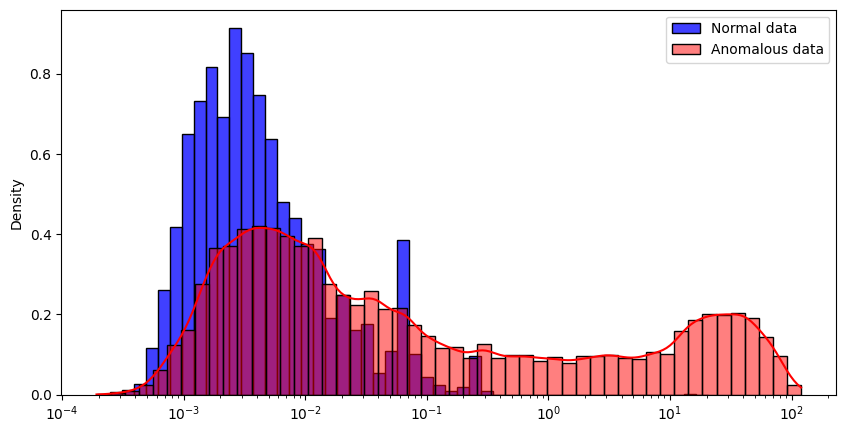

In [52]:
# Plot the loss distribution
plt.figure(figsize=(10, 5))
sns.histplot(normal_loss, kde=False, color='blue', label='Normal data',bins=50,log_scale=(True, False),stat='density')
sns.histplot(anomalous_loss, kde=True, color='red', label='Anomalous data',bins=50,log_scale=(True, False),stat='density')
plt.legend()
plt.show()

# Evaluate Metrics of leakage detection

## Prepare a dataset with and without anomalous data

In [109]:
import numpy as np


# test_sequences, test_flight_ids, test_targets, leak_flows_test
# anomalous_sequences, anomalous_flight_ids, anomalous_targets, leak_flows_anomalous

# Define the number of samples you want to extract
num_samples = 10  # Change this number to the desired number of samples

# Ensure the number of samples does not exceed the number of available sequences
num_samples = min(len(test_sequences), len(anomalous_sequences))

# Randomly select indices
random_indices = np.random.choice(len(test_sequences), num_samples, replace=False)

# Extract samples using the selected indices
sampled_test_sequences = test_sequences[random_indices]
sampled_test_flight_ids = test_flight_ids[random_indices]
sampled_test_targets = test_targets[random_indices]
sampled_leak_flows_test = leak_flows_test[random_indices]

sampled_anomalous_sequences = anomalous_sequences[random_indices]
sampled_anomalous_flight_ids = anomalous_flight_ids[random_indices]
sampled_anomalous_targets = anomalous_targets[random_indices]
sampled_leak_flows_anomalous = leak_flows_anomalous[random_indices]

# Combine the samples vertically
combined_sequences = np.vstack((sampled_test_sequences, sampled_anomalous_sequences))
combined_flight_ids = np.hstack((sampled_test_flight_ids, sampled_anomalous_flight_ids))
combined_targets = np.hstack((sampled_test_targets, sampled_anomalous_targets))
combined_leak_flows = np.vstack((sampled_leak_flows_test, sampled_leak_flows_anomalous))

# Display the combined samples
print("Combined Sequences:\n", combined_sequences)
print("Combined Flight IDs:\n", combined_flight_ids)
print("Combined Targets:\n", combined_targets)
print("Combined Leak Flows:\n", combined_leak_flows)


Combined Sequences:
 [[[-1.57924714e+00 -1.55779507e+00 -1.49237193e-01 ... -2.83561596e+00
   -1.41192503e+00 -1.46115976e+00]
  [-1.57882609e+00 -1.55795701e+00 -1.55242920e-01 ... -2.83561596e+00
   -1.41065942e+00 -1.46147405e+00]
  [-1.57910679e+00 -1.55811895e+00 -1.54065678e-01 ... -2.84359867e+00
   -1.40971020e+00 -1.46210264e+00]
  ...
  [-1.57994888e+00 -1.55892866e+00 -1.53925844e-01 ... -2.86754679e+00
   -1.40907740e+00 -1.46178835e+00]
  [-1.58008923e+00 -1.55909060e+00 -1.54185196e-01 ... -2.86754679e+00
   -1.40907740e+00 -1.46147405e+00]
  [-1.57994888e+00 -1.55925254e+00 -1.57317736e-01 ... -2.86754679e+00
   -1.40876099e+00 -1.46115976e+00]]

 [[-1.60598954e-01 -1.53504306e-01  3.62767600e-02 ... -5.68527700e-01
   -1.43777802e-01 -6.13086311e-02]
  [-1.60598954e-01 -1.53667912e-01  3.45633677e-02 ... -5.52562290e-01
   -1.42828590e-01 -6.25657942e-02]
  [-1.60318256e-01 -1.53831519e-01  2.99767876e-02 ... -5.36596879e-01
   -1.41879378e-01 -6.38229574e-02]
  ...
  

In [113]:
import numpy as np

# Assuming the arrays are already defined: 
# test_sequences, test_flight_ids, test_targets, leak_flows_test
# anomalous_sequences, anomalous_flight_ids, anomalous_targets, leak_flows_anomalous

# Define the number of samples you want to extract
num_samples = 30  # Change this number to the desired number of samples

# Ensure the number of samples does not exceed the number of available flight IDs
unique_test_flight_ids = np.unique(test_flight_ids)
unique_anomalous_flight_ids = np.unique(anomalous_flight_ids)

# common_flight_ids = np.hstack((unique_test_flight_ids, unique_anomalous_flight_ids))

# Get the common flight IDs from both arrays to ensure comparability
# common_flight_ids = np.intersect1d(unique_test_flight_ids, unique_anomalous_flight_ids)

# Ensure the number of samples does not exceed the number of available common flight IDs
# num_samples = min(num_samples, len(common_flight_ids))

# Randomly select flight IDs
random_flight_ids_test = np.random.choice(unique_test_flight_ids, num_samples, replace=False)



random_flight_ids_anomalous = np.random.choice(unique_anomalous_flight_ids, num_samples, replace=False)

# Filter the arrays by the selected flight IDs
def filter_by_flight_ids(sequences, flight_ids, targets, leak_flows, selected_flight_ids):
    indices = np.isin(flight_ids, selected_flight_ids)
    return sequences[indices], flight_ids[indices], targets[indices], leak_flows[indices]

sampled_test_sequences, sampled_test_flight_ids, sampled_test_targets, sampled_leak_flows_test = \
    filter_by_flight_ids(test_sequences, test_flight_ids, test_targets, leak_flows_test, random_flight_ids_test)

sampled_anomalous_sequences, sampled_anomalous_flight_ids, sampled_anomalous_targets, sampled_leak_flows_anomalous = \
    filter_by_flight_ids(anomalous_sequences, anomalous_flight_ids, anomalous_targets, leak_flows_anomalous, random_flight_ids_anomalous)


# Debug prints to check the sizes of the filtered arrays
print("Sampled Test Sequences Shape:", sampled_test_sequences.shape)
print("Sampled Anomalous Sequences Shape:", sampled_anomalous_sequences.shape)
print("Sampled Test Targets Shape:", sampled_test_targets.shape)
print("Sampled Anomalous Targets Shape:", sampled_anomalous_targets.shape)
print("Sampled Leak Flows Test Shape:", sampled_leak_flows_test.shape)
print("Sampled Leak Flows Anomalous Shape:", sampled_leak_flows_anomalous.shape)

sampled_test_targets = sampled_test_targets.max(axis=1)
sampled_anomalous_targets = sampled_anomalous_targets.max(axis=1)


# Combine the samples vertically
combined_sequences = np.vstack((sampled_test_sequences, sampled_anomalous_sequences))
combined_flight_ids = np.hstack((sampled_test_flight_ids, sampled_anomalous_flight_ids))
combined_targets = np.hstack((sampled_test_targets, sampled_anomalous_targets))
combined_leak_flows = np.vstack((sampled_leak_flows_test, sampled_leak_flows_anomalous))

# Display the combined samples
print("Combined Sequences:\n", combined_sequences)
print("Combined Flight IDs:\n", combined_flight_ids)
print("Combined Targets:\n", combined_targets)
print("Combined Leak Flows:\n", combined_leak_flows)

Sampled Test Sequences Shape: (148207, 10, 16)
Sampled Anomalous Sequences Shape: (127953, 10, 16)
Sampled Test Targets Shape: (148207, 10)
Sampled Anomalous Targets Shape: (127953, 10)
Sampled Leak Flows Test Shape: (148207, 10)
Sampled Leak Flows Anomalous Shape: (127953, 10)
Combined Sequences:
 [[[ 0.67237265  0.68754686  0.31810213 ... -0.29711572  0.83612538
    0.74924729]
  [ 0.67153056  0.68726062  0.32372402 ... -0.32904655  0.83485977
    0.74924729]
  [ 0.67054811  0.68691708  0.33018237 ... -0.36097737  0.83485977
    0.74767584]
  ...
  [ 0.66788148  0.68533689  0.34092899 ... -0.51264876  0.83675819
    0.74359006]
  [ 0.66774113  0.68501359  0.33897978 ... -0.53659688  0.837391
    0.74233289]
  [ 0.66802183  0.68469071  0.33272522 ... -0.5685277   0.83865662
    0.74264718]]

 [[ 0.67153056  0.68726062  0.32372402 ... -0.32904655  0.83485977
    0.74924729]
  [ 0.67054811  0.68691708  0.33018237 ... -0.36097737  0.83485977
    0.74767584]
  [ 0.66914462  0.68661172  0.

In [57]:
threshold

0.06261900216341017

## Evaluate

## For anomalous data

In [128]:
anomalous_sampled_loss = evaluate_model(model, anomalous_sequences)

In [129]:
df_leakage_detection_loss = pd.DataFrame(leak_flows_anomalous.max(axis=1),columns=['LEAK_FLOW'])
df_leakage_detection_loss['loss'] = anomalous_sampled_loss
df_leakage_detection_loss['anomaly'] = (anomalous_sampled_loss > threshold).astype(int)
df_leakage_detection_loss['Flight'] = anomalous_flight_ids
# df_leakage_detection_loss['UTC_TIME'] = anomalous_data_scaled_df.index
df_leakage_detection_loss['LEAK_FLOW_CATEGORY'] = np.where(df_leakage_detection_loss['LEAK_FLOW']>=1 , 'High', 'Low').astype(object)
df_leakage_detection_loss

,LEAK_FLOW,loss,anomaly,Flight,LEAK_FLOW_CATEGORY
0,0.16,0.006682,0,02_V0837,Low
1,0.16,0.007914,0,02_V0837,Low
2,0.16,0.008826,0,02_V0837,Low
3,0.16,0.008497,0,02_V0837,Low
4,0.16,0.008161,0,02_V0837,Low
...,...,...,...,...,...
1202228,0.01,0.006200,0,53_95.0,Low
1202229,0.01,0.006292,0,53_95.0,Low
1202230,0.01,0.006244,0,53_95.0,Low
1202231,0.01,0.006200,0,53_95.0,Low


In [86]:
# df_flights_anomalies = df_leakage_detection_loss.groupby('Flight').agg({'anomaly':'max','LEAK_FLOW':'max'}).reset_index()

# list_leak_flows = df_flights_anomalies['LEAK_FLOW'].unique()
# for leak in list_leak_flows:
#     df_filtered = df_flights_anomalies['LEAK_FLOW'].isin([leak])

,Flight,anomaly,LEAK_FLOW
0,02_V0837,0,0.16
1,02_V0884,0,0.64
2,02_V0889,0,0.01
3,02_V0926,0,0.16
4,02_V0927,1,5.12
...,...,...,...
233,53_58.0,0,1.28
234,53_66.0,0,1.28
235,53_9.0,0,0.64
236,53_90.0,1,0.08


In [130]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Group by Flight and aggregate anomaly and LEAK_FLOW
df_flights_anomalies = df_leakage_detection_loss.groupby('Flight').agg({'anomaly':'max','LEAK_FLOW':'max'}).reset_index()

# Get unique leak flows
list_leak_flows = df_flights_anomalies['LEAK_FLOW'].unique()

# Initialize a list to store the results
results = []

# Loop through each unique leak flow
for leak in list_leak_flows:
    # Filter the DataFrame for the current leak flow
    df_filtered = df_flights_anomalies[df_flights_anomalies['LEAK_FLOW'] == leak]
    
    # Extract true labels and predicted labels
    # Here, we assume that if there is any leak flow, it's an anomaly, so y_true should be all 1s
    y_true = np.where(df_filtered['LEAK_FLOW'] >= 0, 1, 0)
    y_pred = df_filtered['anomaly']            # Assuming anomaly column indicates the detected condition
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel() if len(y_true) > 1 else (0, 0, 0, sum(y_pred))
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    # Append the results to the list
    results.append({
        'LEAK_FLOW': leak,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'false_positive_rate': false_positive_rate
    })

# Convert the results list to a DataFrame
df_metrics = pd.DataFrame(results)

#order results by leak flow
df_metrics = df_metrics.sort_values(by='LEAK_FLOW')
df_metrics


,LEAK_FLOW,accuracy,precision,recall,f1,false_positive_rate
2,0.01,0.111111,1.0,0.111111,0.200000,0
9,0.02,0.041667,1.0,0.041667,0.080000,0
6,0.04,0.130435,1.0,0.130435,0.230769,0
8,0.08,0.160000,1.0,0.160000,0.275862,0
0,0.16,0.181818,1.0,0.181818,0.307692,0
4,0.32,0.291667,1.0,0.291667,0.451613,0
1,0.64,0.500000,1.0,0.500000,0.666667,0
7,1.28,0.545455,1.0,0.545455,0.705882,0
5,2.56,0.750000,1.0,0.750000,0.857143,0
3,5.12,0.640000,1.0,0.640000,0.780488,0


## For normal

In [142]:
test_loss = evaluate_model(model, test_sequences)

In [143]:
df_leakage_detection_loss = pd.DataFrame(leak_flows_test.max(axis=1),columns=['LEAK_FLOW'])
df_leakage_detection_loss['loss'] = test_loss
df_leakage_detection_loss['anomaly'] = (test_loss > threshold).astype(int)
df_leakage_detection_loss['Flight'] = test_flight_ids
# df_leakage_detection_loss['UTC_TIME'] = anomalous_data_scaled_df.index
df_leakage_detection_loss['LEAK_FLOW_CATEGORY'] = np.where(df_leakage_detection_loss['LEAK_FLOW']>=1 , 'High', 'Low').astype(object)
df_leakage_detection_loss

,LEAK_FLOW,loss,anomaly,Flight,LEAK_FLOW_CATEGORY
0,0.0,0.006016,0,11_1827.0,Low
1,0.0,0.006027,0,11_1827.0,Low
2,0.0,0.006019,0,11_1827.0,Low
3,0.0,0.005885,0,11_1827.0,Low
4,0.0,0.005905,0,11_1827.0,Low
...,...,...,...,...,...
213364,0.0,0.002161,0,53_96.0,Low
213365,0.0,0.002139,0,53_96.0,Low
213366,0.0,0.001984,0,53_96.0,Low
213367,0.0,0.002133,0,53_96.0,Low


In [144]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Group by Flight and aggregate anomaly and LEAK_FLOW
df_flights_anomalies = df_leakage_detection_loss.groupby('Flight').agg({'anomaly':'max','LEAK_FLOW':'max'}).reset_index()

# Get unique leak flows
list_leak_flows = df_flights_anomalies['LEAK_FLOW'].unique()

# Initialize a list to store the results
results = []

# Loop through each unique leak flow
for leak in list_leak_flows:
    # Filter the DataFrame for the current leak flow
    df_filtered = df_flights_anomalies[df_flights_anomalies['LEAK_FLOW'] == leak]
    
    # Extract true labels and predicted labels
    # Here, we assume that if there is any leak flow, it's an anomaly, so y_true should be all 1s
    y_true = np.where(df_filtered['LEAK_FLOW'] >= 0, 1, 0)
    y_pred = df_filtered['anomaly']            # Assuming anomaly column indicates the detected condition
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel() if len(y_true) > 1 else (0, 0, 0, sum(y_pred))
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    # Append the results to the list
    results.append({
        'LEAK_FLOW': leak,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'false_positive_rate': false_positive_rate
    })

# Convert the results list to a DataFrame
df_metrics = pd.DataFrame(results)

#order results by leak flow
df_metrics = df_metrics.sort_values(by='LEAK_FLOW')
df_metrics


,LEAK_FLOW,accuracy,precision,recall,f1,false_positive_rate
0,0.0,0.086957,1.0,0.086957,0.16,0


## Combined

In [145]:
combined_loss = evaluate_model(model, combined_sequences)

In [146]:
df_leakage_detection_loss = pd.DataFrame(combined_leak_flows.max(axis=1),columns=['LEAK_FLOW'])
df_leakage_detection_loss['loss'] = combined_loss
df_leakage_detection_loss['anomaly'] = (combined_loss > threshold).astype(int)
df_leakage_detection_loss['Flight'] = combined_flight_ids
# df_leakage_detection_loss['UTC_TIME'] = anomalous_data_scaled_df.index
df_leakage_detection_loss['LEAK_FLOW_CATEGORY'] = np.where(df_leakage_detection_loss['LEAK_FLOW']>=1 , 'High', 'Low').astype(object)
df_leakage_detection_loss['TARGET'] = np.where(df_leakage_detection_loss['LEAK_FLOW']>0 , 1, 0).astype(int)
df_leakage_detection_loss

,LEAK_FLOW,loss,anomaly,Flight,LEAK_FLOW_CATEGORY,TARGET
0,0.00,0.006016,0,11_1827.0,Low,0
1,0.00,0.006027,0,11_1827.0,Low,0
2,0.00,0.006019,0,11_1827.0,Low,0
3,0.00,0.005885,0,11_1827.0,Low,0
4,0.00,0.005905,0,11_1827.0,Low,0
...,...,...,...,...,...,...
276155,1.28,0.009435,0,53_58.0,High,1
276156,1.28,0.008916,0,53_58.0,High,1
276157,1.28,0.009412,0,53_58.0,High,1
276158,1.28,0.009047,0,53_58.0,High,1


In [147]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Group by Flight and aggregate anomaly and LEAK_FLOW
df_flights_anomalies = df_leakage_detection_loss.groupby('Flight').agg({'anomaly':'max','TARGET':'max'}).reset_index()

df_flights_anomalies

,Flight,anomaly,TARGET
0,11_1827.0,0,0
1,11_1828.0,0,1
2,11_1865.0,0,0
3,11_1872.0,0,1
4,11_1909.0,0,0
5,11_1911.0,0,0
6,11_1937.0,0,1
7,11_1987.0,0,0
8,11_2014.0,0,0
9,11_2016.0,0,1


In [148]:
y_true= df_flights_anomalies['TARGET']
y_pred = df_flights_anomalies['anomaly']
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel() if len(y_true) > 1 else (0, 0, 0, sum(y_pred))
false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

#print results
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


Accuracy: 0.6
Precision: 0.8
Recall: 0.26666666666666666
F1 Score: 0.4
